load libraries

In [21]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

# 加载数据集

In [2]:
basedir = "/ext/Data/distracted_driver_detection/"

model_image_size = 224

print("-------- loading train data")
X_train = list()
y_train = list()
for i in range(10):
    dir = os.path.join(basedir, "train", "c%d"%i)
    image_files = glob.glob(os.path.join(dir,"*.jpg"))
    print("loding {}, image count={}".format(dir, len(image_files)))
    for image_file in image_files:
        image = cv2.imread(image_file)
        X_train.append(cv2.resize(image, (model_image_size, model_image_size)))
        label = np.zeros(10, dtype=np.uint8)
        label[i]=1
        y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)
        
print("-------- loading valid data")
X_valid = list()
y_valid = list()
for i in range(10):
    dir = os.path.join(basedir, "valid", "c%d"%i)
    image_files = glob.glob(os.path.join(dir,"*.jpg"))
    print("loding {}, image count={}".format(dir, len(image_files)))
    for image_file in image_files:
        image = cv2.imread(image_file)
        X_valid.append(cv2.resize(image, (model_image_size, model_image_size)))
        label = np.zeros(10, dtype=np.uint8)
        label[i]=1
        y_valid.append(label)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

-------- loading train data
loding /ext/Data/distracted_driver_detection/train/c0, image count=2308
loding /ext/Data/distracted_driver_detection/train/c1, image count=2096
loding /ext/Data/distracted_driver_detection/train/c2, image count=2136
loding /ext/Data/distracted_driver_detection/train/c3, image count=2185
loding /ext/Data/distracted_driver_detection/train/c4, image count=2160
loding /ext/Data/distracted_driver_detection/train/c5, image count=2152
loding /ext/Data/distracted_driver_detection/train/c6, image count=2164
loding /ext/Data/distracted_driver_detection/train/c7, image count=1843
loding /ext/Data/distracted_driver_detection/train/c8, image count=1771
loding /ext/Data/distracted_driver_detection/train/c9, image count=1972
-------- loading valid data
loding /ext/Data/distracted_driver_detection/valid/c0, image count=181
loding /ext/Data/distracted_driver_detection/valid/c1, image count=171
loding /ext/Data/distracted_driver_detection/valid/c2, image count=181
loding /ext

# 分为训练集和验证集

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(20787, 224, 224, 3)
(20787, 10)
(1637, 224, 224, 3)
(1637, 10)


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py


In [5]:
base_model = VGG16(input_tensor=Input((model_image_size, model_image_size, 3)), weights='imagenet', include_top=False)

z = zip([x.name for x in base_model.layers], range(len(base_model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_1 - 0
block1_conv1 - 1
block1_conv2 - 2
block1_pool - 3
block2_conv1 - 4
block2_conv2 - 5
block2_pool - 6
block3_conv1 - 7
block3_conv2 - 8
block3_conv3 - 9
block3_pool - 10
block4_conv1 - 11
block4_conv2 - 12
block4_conv3 - 13
block4_pool - 14
block5_conv1 - 15
block5_conv2 - 16
block5_conv3 - 17
block5_pool - 18


In [7]:
for i in range(16):
    base_model.layers[i].trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(10, activation='softmax')(x)
model = Model(base_model.input, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("done")

done


# 训练模型

In [8]:
model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_valid, y_valid))
model.save("models/vgg16-mymodel.h5")

Train on 20787 samples, validate on 1637 samples
Epoch 1/30
20787/20787 [==============================] - 99s - loss: 0.5453 - acc: 0.9027 - val_loss: 0.2160 - val_acc: 0.9188

# 可视化模型

https://keras.io/visualization/

load successed


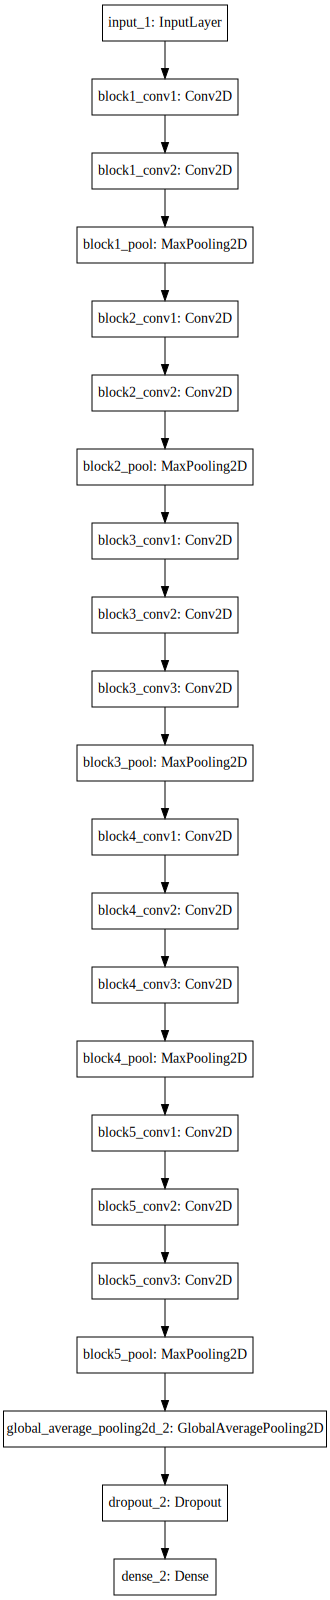

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/vgg16-mymodel.h5")
print("load successed")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [10]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_1 - 0
block1_conv1 - 1
block1_conv2 - 2
block1_pool - 3
block2_conv1 - 4
block2_conv2 - 5
block2_pool - 6
block3_conv1 - 7
block3_conv2 - 8
block3_conv3 - 9
block3_pool - 10
block4_conv1 - 11
block4_conv2 - 12
block4_conv3 - 13
block4_pool - 14
block5_conv1 - 15
block5_conv2 - 16
block5_conv3 - 17
block5_pool - 18
global_average_pooling2d_2 - 19
dropout_2 - 20
dense_2 - 21


http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [11]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = os.path.join(basedir,  "test", "test" )
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 14))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = cv2.imread(image_files[2000*i+113])
        img = cv2.resize(img, (model_image_size, model_image_size))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size, model_image_size))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output Tensor("block5_pool_1/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
weights shape (512, 10)
79726


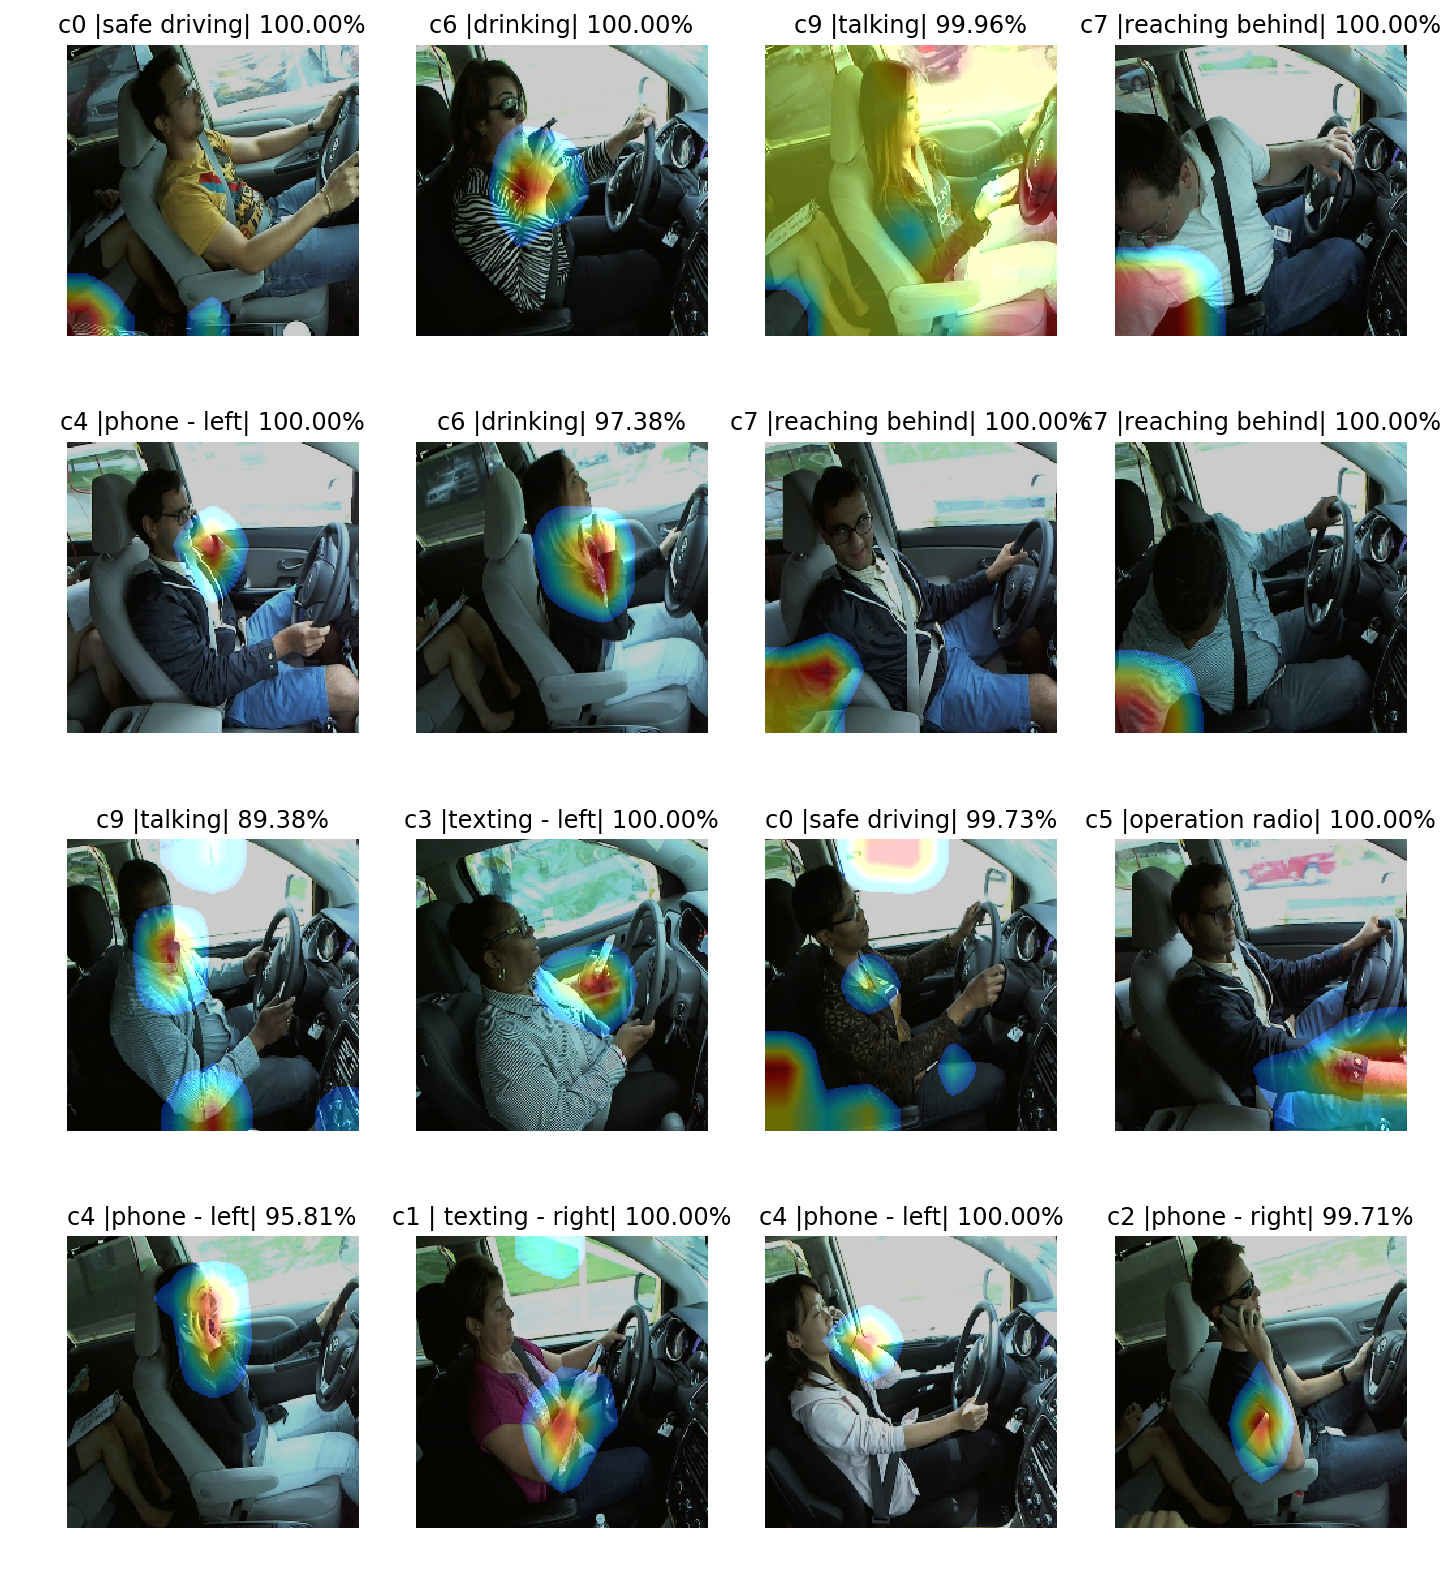

In [12]:
weights = model.layers[21].get_weights()[0]
layer_output = model.layers[18].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

In [16]:
def gen_kaggle_csv(model, X_test,  model_image_size, csv_name):
    y_pred = model.predict(X_test, verbose=1)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    print()
    print(y_pred[:3])

    dir = "/ext/Data/distracted_driver_detection/"

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(dir + "test/", (model_image_size, model_image_size), shuffle=False, 
                                             batch_size=16, class_mode=None)

    l = list()
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        l.append( [name, *y_pred[i]] )

    l = np.array(l)
    data = {'img': l[:,0]}
    for i in range(10):
        data["c%d"%i] = l[:,i+1]
    df = pd.DataFrame(data, columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name, index=None, float_format='%.3f')

print("done")

done


In [18]:
print("-------- loading test data")
X_test = list()
dir = os.path.join(basedir, "test/test")
image_files = glob.glob(os.path.join(dir,"*.jpg"))
print("loading {}, image count={}".format(dir, len(image_files)))
for image_file in image_files:
    image = cv2.imread(image_file)
    X_test.append(cv2.resize(image, (model_image_size, model_image_size)))
X_test = np.array(X_test)
print(X_test.shape)

-------- loading test data
loading /ext/Data/distracted_driver_detection/test/test, image count=79726
(79726, 224, 224, 3)


In [22]:
gen_kaggle_csv(model,  X_test,  model_image_size, 'csv/vgg16-with-train-pred.csv')

79726/79726 [==============================] - 305s     